<a href="https://colab.research.google.com/github/Tanyapong/NLP-Spam-Detection/blob/main/Deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
#import the important library
import sys
import nltk
import sklearn #for the prepocess library
import pandas
import numpy

print('Python: {}'.format(sys.version))
print('NLTK: {}'.format(nltk.__version__))
print('Scikit-learn: {}'.format(sklearn.__version__))
print('Pandas: {}'.format(pandas.__version__))
print('Numpy: {}'.format(numpy.__version__))

Python: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]
NLTK: 3.2.5
Scikit-learn: 0.22.2.post1
Pandas: 1.1.4
Numpy: 1.18.5


# **Load the dataset**

In [3]:
#the library to discover/exploring the data 
import pandas as pd
import numpy as np
import seaborn as sns
#for plotting the data
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

# load the dataset of SMS messages
df = pd.read_table('/content/drive/My Drive/Colab Notebooks/smsspamcollection/SMSSpamCollection', header=None, encoding='utf-8',names=["label","message"])


In [4]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [5]:
df.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [6]:
#check for duplication and we can see that it have the duplication of the sms
duplicatedRow = df[df.duplicated()]
print(duplicatedRow[:5])

    label                                            message
103   ham  As per your request 'Melle Melle (Oru Minnamin...
154   ham  As per your request 'Melle Melle (Oru Minnamin...
207   ham  As I entered my cabin my PA said, '' Happy B'd...
223   ham                             Sorry, I'll call later
326   ham                   No calls..messages..missed calls


In [7]:
df.groupby('label').describe().T

label                              ham                                               spam
message count                     4825                                                747
        unique                    4516                                                653
        top     Sorry, I'll call later  Please call our customer service representativ...
        freq                        30                                                  4

In [8]:
#Create the wordcloud for visualisation more detail inside the data
# Get all the ham and spam emails
ham_msg = df[df.label =='ham']
spam_msg = df[df.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_txt = " ".join(ham_msg.message.to_numpy().tolist()) #convert to numpy array
spam_msg_txt = " ".join(spam_msg.message.to_numpy().tolist())

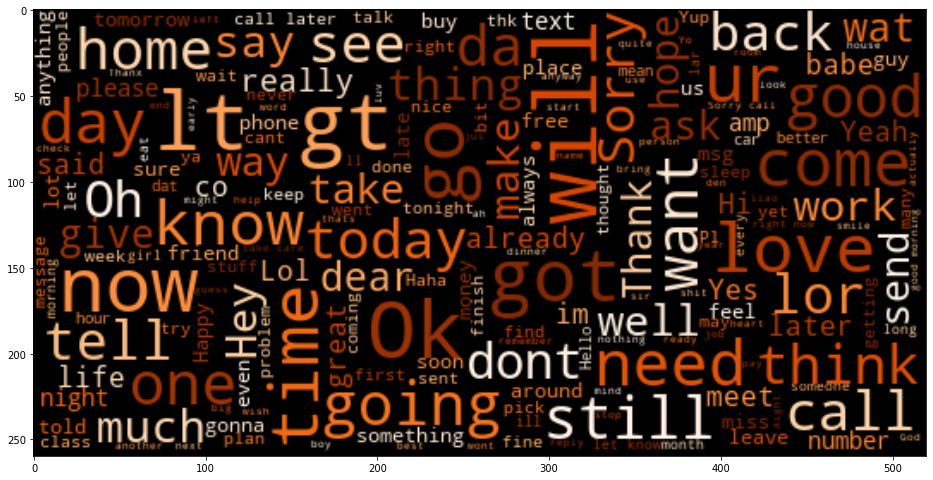

In [9]:
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Oranges').generate(ham_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('on')
plt.show()

#by this experiment we can see that the common word of ham is "Ok" "will" "love" "It" "time" "know" "tell"

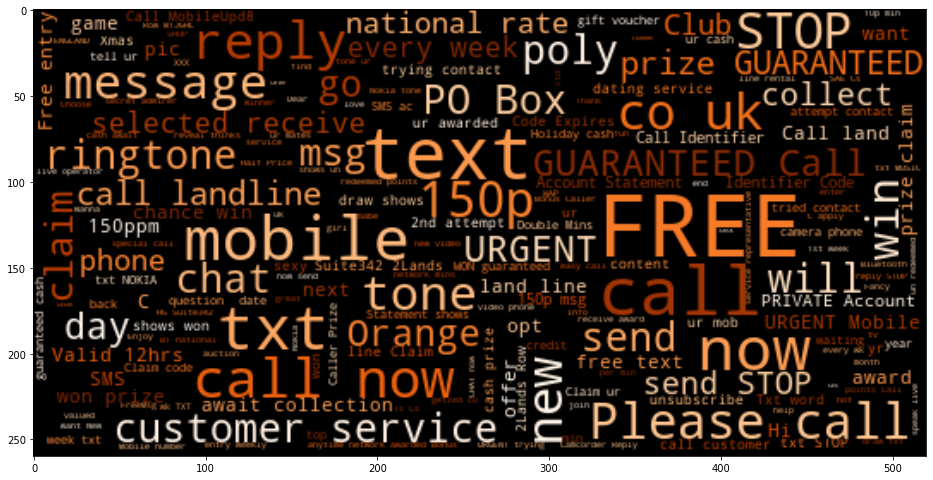

In [10]:
# wordcloud of spam messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Oranges').generate(spam_msg_txt)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('on')
plt.show()

#by this experiment we can see that the common word of ham is "Free" "text" "call" "Please" "mobile" "message"

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


15.481865284974095

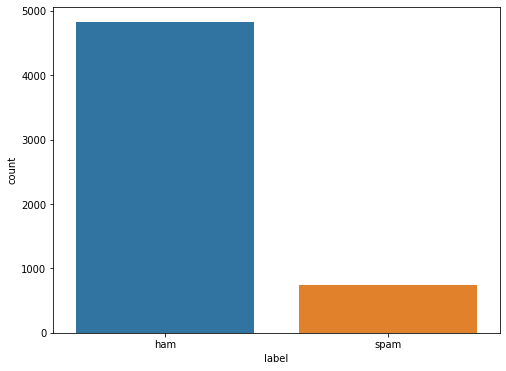

In [11]:
# we can observe imbalance data here 
plt.figure(figsize=(8,6))
sns.countplot(df.label)
# Percentage of spam messages
(len(spam_msg)/len(ham_msg))*100
#we have the ham massage more than the spam massage very much which create imbalance

In [12]:
#Under/Down sampling
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(747, 2) (747, 2)


In [13]:
#Over/Up sampling #WE USE THIS!!!!!!!!!
spam_msg_df = spam_msg.sample(n = len(ham_msg), random_state = 44, replace=True)
ham_msg_df = ham_msg
print(ham_msg_df.shape, spam_msg_df.shape)

(4825, 2) (4825, 2)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

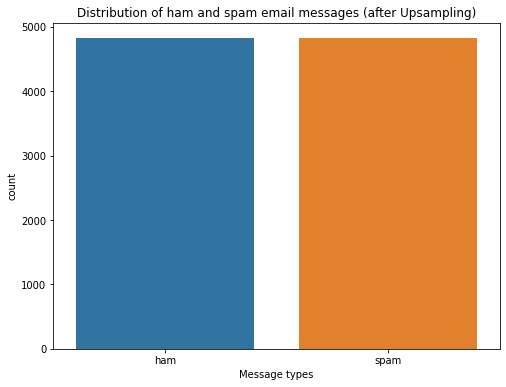

In [14]:
# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after Upsampling)')
plt.xlabel('Message types')

In [15]:
#Get text lenght which use in the maxlen parameter
msg_df['text_length'] = msg_df['message'].apply(len)
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,71.482487
spam,138.900518


# **Preprocess the dataset**

In [16]:
msg_df

,label,message,text_length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,ham,U dun say so early hor... U c already then say...,49
3,ham,"Nah I don't think he goes to usf, he lives aro...",61
4,ham,Even my brother is not like to speak with me. ...,77
...,...,...,...
9645,spam,URGENT! We are trying to contact U. Todays dra...,156
9646,spam,Moby Pub Quiz.Win a £100 High Street prize if ...,160
9647,spam,Summers finally here! Fancy a chat or flirt wi...,159
9648,spam,For ur chance to win a £250 wkly shopping spre...,126


In [17]:
from sklearn import model_selection

# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values

In [18]:
#Regular expression to make our message data to be understanding easily and the confusion
processed = msg_df.message.replace(r'^\w+@[a-zA-Z_]+?\.[a-zA-Z]{2,3}$','email')

processed = msg_df.message.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddr')

processed = msg_df.message.replace(r'£|$','moneysymb')

processed = msg_df.message.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')

processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

# Remove punctuation
processed = processed.str.replace(r'[^\w\d\s]', ' ')

# Replace whitespace between terms with a single space
processed = processed.str.replace(r'\s+', ' ')

# Remove leading and trailing whitespace
processed = processed.str.replace(r'^\s+|\s+?$', '')

In [19]:
processed = processed.str.lower()
print(processed)

0       go until jurong point crazy available only in ...
1                                 ok lar joking wif u oni
2             u dun say so early hor u c already then say
3       nah i don t think he goes to usf he lives arou...
4       even my brother is not like to speak with me t...
                              ...                        
9645    urgent we are trying to contact u todays draw ...
9646    moby pub quiz win a numbr high street prize if...
9647    summers finally here fancy a chat or flirt wit...
9648    for ur chance to win a numbr wkly shopping spr...
9649    claire here am havin borin time am now alone u...
Name: message, Length: 9650, dtype: object


In [20]:
#download stopwords to remove the verbage stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
from nltk.corpus import stopwords

# remove stop words from text messages

stop_words = set(stopwords.words('english'))

processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))

In [22]:
# Remove word stems using a Porter stemmer
ps = nltk.PorterStemmer()

processed = processed.apply(lambda x: ' '.join(
    ps.stem(term) for term in x.split()))

In [23]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = model_selection.train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [25]:
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

In [26]:
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_msg)

In [27]:
# Get the word_index 
word_index = tokenizer.word_index
word_index

{'<OOV>': 1,
 'to': 2,
 'you': 3,
 'a': 4,
 'call': 5,
 'i': 6,
 'the': 7,
 'your': 8,
 'u': 9,
 'for': 10,
 'is': 11,
 'and': 12,
 'now': 13,
 '2': 14,
 'free': 15,
 'or': 16,
 'in': 17,
 'on': 18,
 'have': 19,
 'of': 20,
 'ur': 21,
 'txt': 22,
 '4': 23,
 'from': 24,
 'me': 25,
 'with': 26,
 'are': 27,
 'stop': 28,
 'get': 29,
 'this': 30,
 'my': 31,
 'mobile': 32,
 'text': 33,
 'it': 34,
 'no': 35,
 'just': 36,
 'be': 37,
 'claim': 38,
 'reply': 39,
 'only': 40,
 'will': 41,
 'that': 42,
 'prize': 43,
 'send': 44,
 'www': 45,
 'our': 46,
 'we': 47,
 'out': 48,
 'so': 49,
 'not': 50,
 'can': 51,
 'if': 52,
 'do': 53,
 'at': 54,
 'but': 55,
 'new': 56,
 'go': 57,
 'cash': 58,
 'all': 59,
 't': 60,
 'nokia': 61,
 'won': 62,
 '150p': 63,
 "i'm": 64,
 'phone': 65,
 'msg': 66,
 'please': 67,
 '1': 68,
 'urgent': 69,
 'up': 70,
 'week': 71,
 'win': 72,
 'uk': 73,
 'who': 74,
 'com': 75,
 'been': 76,
 'know': 77,
 'contact': 78,
 'as': 79,
 'service': 80,
 'when': 81,
 'what': 82,
 '50': 83,

In [28]:
# check how many words 
tot_words = len(word_index)
print('There are %s unique tokens in training data. ' % tot_words)


There are 8256 unique tokens in training data. 


In [29]:
# Sequencing and padding on training and testing 
training_sequences = tokenizer.texts_to_sequences(train_msg)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_msg)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [30]:
# Shape of train tensor
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (7720, 50)
Shape of testing tensor:  (1930, 50)


In [31]:
# Before padding
len(training_sequences[0]), len(training_sequences[1])

(10, 5)

In [32]:
# After padding
len(training_padded[0]), len(training_padded[1])

(50, 50)

In [33]:
print(training_padded[0])

[204 204 206 405   3 130 191  12   1   1   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


# **The Dense Layer**

In [34]:
vocab_size = 500 # As defined earlier
embeding_dim = 16
drop_value = 0.2 # dropout
n_dense = 24

In [35]:
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [37]:
model.compile(loss='binary_crossentropy',optimizer='adam' ,metrics=['accuracy'])

In [38]:
# fitting a dense spam detector model
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
242/242 - 1s - loss: 0.5496 - accuracy: 0.7918 - val_loss: 0.3362 - val_accuracy: 0.8953
Epoch 2/30
242/242 - 0s - loss: 0.2199 - accuracy: 0.9345 - val_loss: 0.1444 - val_accuracy: 0.9508
Epoch 3/30
242/242 - 0s - loss: 0.1211 - accuracy: 0.9640 - val_loss: 0.0983 - val_accuracy: 0.9699
Epoch 4/30
242/242 - 0s - loss: 0.0923 - accuracy: 0.9707 - val_loss: 0.0798 - val_accuracy: 0.9736
Epoch 5/30
242/242 - 0s - loss: 0.0786 - accuracy: 0.9734 - val_loss: 0.0667 - val_accuracy: 0.9777
Epoch 6/30
242/242 - 0s - loss: 0.0652 - accuracy: 0.9775 - val_loss: 0.0602 - val_accuracy: 0.9793
Epoch 7/30
242/242 - 0s - loss: 0.0588 - accuracy: 0.9793 - val_loss: 0.0517 - val_accuracy: 0.9834
Epoch 8/30
242/242 - 0s - loss: 0.0528 - accuracy: 0.9837 - val_loss: 0.0483 - val_accuracy: 0.9850
Epoch 9/30
242/242 - 0s - loss: 0.0478 - accuracy: 0.9834 - val_loss: 0.0429 - val_accuracy: 0.9876
Epoch 10/30
242/242 - 0s - loss: 0.0415 - accuracy: 0.9854 - val_loss: 0.0404 - val_accuracy: 0.9860

In [39]:
# Model performance on test data 
model.evaluate(testing_padded, test_labels)

61/61 [==============================] - 0s 802us/step - loss: 0.0306 - accuracy: 0.9912


[0.03055117279291153, 0.9911916851997375]

In [40]:
# Read as a dataframe 
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy', 'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])

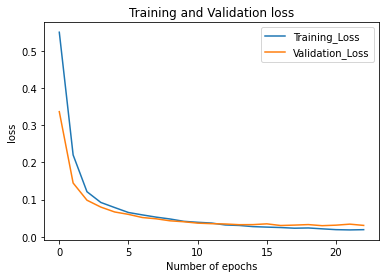

In [41]:
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')

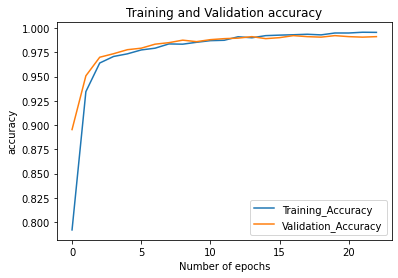

In [42]:
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# **The LSTM (Lng Short Term Memory)**

In [43]:
#LSTM hyperparameters
n_lstm = 20
drop_lstm =0.2

In [44]:
#LSTM Spam detection architecture
model1 = Sequential()
model1.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)) #In keras just add the LSTM into our model
model1.add(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True))
model1.add(Dense(1, activation='sigmoid'))

In [45]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [46]:
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model1.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
242/242 - 9s - loss: 0.3144 - accuracy: 0.8685 - val_loss: 0.1771 - val_accuracy: 0.9409
Epoch 2/30
242/242 - 9s - loss: 0.1526 - accuracy: 0.9471 - val_loss: 0.1404 - val_accuracy: 0.9477
Epoch 3/30
242/242 - 9s - loss: 0.1240 - accuracy: 0.9557 - val_loss: 0.1286 - val_accuracy: 0.9527
Epoch 4/30
242/242 - 9s - loss: 0.1165 - accuracy: 0.9555 - val_loss: 0.1262 - val_accuracy: 0.9504
Epoch 5/30
242/242 - 9s - loss: 0.1019 - accuracy: 0.9619 - val_loss: 0.1264 - val_accuracy: 0.9529
Epoch 6/30
242/242 - 9s - loss: 0.1094 - accuracy: 0.9595 - val_loss: 0.1579 - val_accuracy: 0.9380


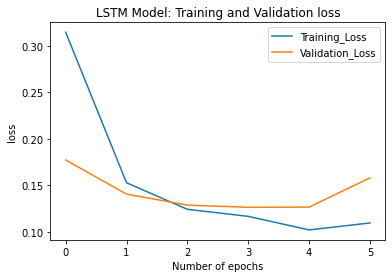

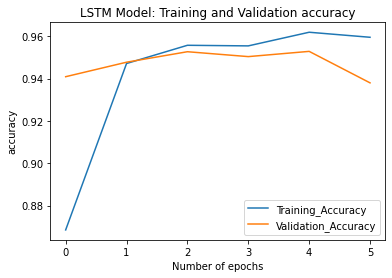

In [47]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('LSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

# **Bidirectional model**

In [48]:
# Biderectional LSTM Spam detection architecture
model2 = Sequential()
model2.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model2.add(Bidirectional(LSTM(n_lstm, dropout=drop_lstm, return_sequences=True)))
model2.add(Dense(1, activation='sigmoid'))

In [49]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [50]:
# Training
num_epochs = 30
early_stop = EarlyStopping(monitor='val_loss', patience=2)
history = model2.fit(training_padded, train_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, test_labels),callbacks =[early_stop], verbose=2)

Epoch 1/30
242/242 - 7s - loss: 0.3146 - accuracy: 0.8722 - val_loss: 0.1256 - val_accuracy: 0.9667
Epoch 2/30
242/242 - 6s - loss: 0.1050 - accuracy: 0.9709 - val_loss: 0.0874 - val_accuracy: 0.9755
Epoch 3/30
242/242 - 6s - loss: 0.0774 - accuracy: 0.9785 - val_loss: 0.0634 - val_accuracy: 0.9807
Epoch 4/30
242/242 - 6s - loss: 0.0590 - accuracy: 0.9833 - val_loss: 0.0494 - val_accuracy: 0.9864
Epoch 5/30
242/242 - 6s - loss: 0.0504 - accuracy: 0.9849 - val_loss: 0.0459 - val_accuracy: 0.9859
Epoch 6/30
242/242 - 6s - loss: 0.0406 - accuracy: 0.9872 - val_loss: 0.0472 - val_accuracy: 0.9831
Epoch 7/30
242/242 - 6s - loss: 0.0381 - accuracy: 0.9874 - val_loss: 0.0398 - val_accuracy: 0.9878
Epoch 8/30
242/242 - 6s - loss: 0.0312 - accuracy: 0.9906 - val_loss: 0.0535 - val_accuracy: 0.9856
Epoch 9/30
242/242 - 6s - loss: 0.0282 - accuracy: 0.9914 - val_loss: 0.0410 - val_accuracy: 0.9883


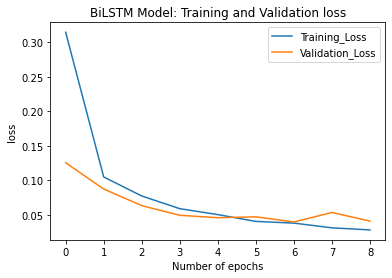

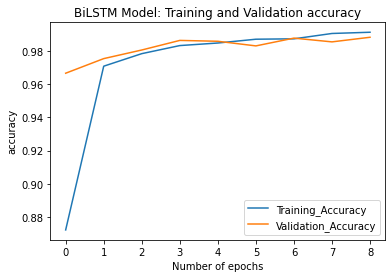

In [51]:
# Create a dataframe
metrics = pd.DataFrame(history.history)
# Rename column
metrics.rename(columns = {'loss': 'Training_Loss', 'accuracy': 'Training_Accuracy',
                         'val_loss': 'Validation_Loss', 'val_accuracy': 'Validation_Accuracy'}, inplace = True)
def plot_graphs1(var1, var2, string):
    metrics[[var1, var2]].plot()
    plt.title('BiLSTM Model: Training and Validation ' + string)
    plt.xlabel ('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
# Plot
plot_graphs1('Training_Loss', 'Validation_Loss', 'loss')
plot_graphs1('Training_Accuracy', 'Validation_Accuracy', 'accuracy')

In [52]:
# Comparing three different models
print(f"Dense architecture loss and accuracy: {model.evaluate(testing_padded, test_labels)} " )
print(f"LSTM architecture loss and accuracy: {model1.evaluate(testing_padded, test_labels)} " )
print(f"Bi-LSTM architecture loss and accuracy: {model2.evaluate(testing_padded, test_labels)} " )

61/61 [==============================] - 0s 922us/step - loss: 0.0306 - accuracy: 0.9912
Dense architecture loss and accuracy: [0.03055117279291153, 0.9911916851997375] 
61/61 [==============================] - 0s 8ms/step - loss: 0.1579 - accuracy: 0.9380
LSTM architecture loss and accuracy: [0.1578628569841385, 0.9379792213439941] 
61/61 [==============================] - 0s 6ms/step - loss: 0.0410 - accuracy: 0.9883
Bi-LSTM architecture loss and accuracy: [0.04097200930118561, 0.9883420467376709] 


By the result we use dense as a model
# **Testing on dense model**

In [53]:
pd.options.display.max_colwidth=150
msg_df[:9645]

,label,message,text_length,msg_type
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,0
1,ham,Ok lar... Joking wif u oni...,29,0
2,ham,U dun say so early hor... U c already then say...,49,0
3,ham,"Nah I don't think he goes to usf, he lives around here though",61,0
4,ham,Even my brother is not like to speak with me. They treat me like aids patent.,77,0
...,...,...,...,...
9640,spam,Marvel Mobile Play the official Ultimate Spider-man game (£4.50) on ur mobile right now. Text SPIDER to 83338 for the game & we ll send u a FREE 8...,160,1
9641,spam,"Latest News! Police station toilet stolen, cops have nothing to go on!",70,1
9642,spam,"Customer service announcement. We recently tried to make a delivery to you but were unable to do so, please call 07099833605 to re-schedule. Ref:9...",152,1
9643,spam,"SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info",136,1


In [54]:
predict_msg = ["Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
          "U dun say so early hor... U c already then say...",
          "Marvel Mobile Play the official Ultimate Spider-man game (£4.50) on ur mobile right now. Text SPIDER to 83338 for the game & we ll send u a FREE 8..."]

In [55]:
# Defining prediction function
def predict_spam(predict_msg):
    new_seq = tokenizer.texts_to_sequences(predict_msg)
    padded = pad_sequences(new_seq, maxlen =max_len,
                      padding = padding_type,
                      truncating=trunc_type)
    return (model.predict(padded))
predict_spam(predict_msg)

array([[5.7511013e-08],
       [1.5799640e-06],
       [9.9977541e-01]], dtype=float32)

# **Demo testing of our model**

In [56]:
# The newly created message
predict_msg = ["You are awarded a Nikon Digital Camera. Call now",
               "Call me",
          "What's up?"]
predict_spam(predict_msg)

array([[0.9876443],
       [0.0044187],
       [0.0011054]], dtype=float32)